# Extract Tags
This is a notebook to extract images from a ROS 1 bagfile, detect the aruco markers, and output a bag of AprilTag detections.

In [1]:
#!/usr/bin/env python3

from rosbags.highlevel import AnyReader
from rosbags.image import message_to_cvimage
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from apriltag_msgs.msg import ApriltagArrayStamped, Apriltag
from geometry_msgs.msg import Point
import rospy

# Set up paths
bag_file_path = Path('/home/asekar/Documents/trisect_ws/src/trisect_data/2023-07-21_head_orbit/cropped.bag')
image_topic = '/trisect/stereo/left/image_rect'

In [2]:
def extract_and_generate_apriltag_msg(bag_file_path, image_topic, encoding="bgr8"):
    # Set up the ArUco dictionary and parameters for detection
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    # Open the bag file with AnyReader
    with AnyReader([bag_file_path]) as reader:
        connections = [x for x in reader.connections if x.topic == image_topic]
        
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            # Deserialize the message
            msg = reader.deserialize(rawdata, connection.msgtype)
            
            # Print the header
            print("Header:", msg.header)
            
            # Convert ROS message to OpenCV image
            cv_image = message_to_cvimage(msg, encoding)
            
            # Detect ArUco markers
            corners, ids, rejected = detector.detectMarkers(cv_image)
            
            # Draw detected markers on the image
            if ids is not None:
                cv_image = cv2.aruco.drawDetectedMarkers(cv_image, corners, ids)

                # Create the ApriltagArrayStamped message
                apriltag_array_msg = ApriltagArrayStamped()
                apriltag_array_msg.header.stamp = msg.header.stamp  
                apriltag_array_msg.header.frame_id = "camera_frame"  # Update this to match your frame

                # Loop over detected ArUco markers to populate ApriltagArrayStamped
                for i, corner in enumerate(corners):
                    apriltag_msg = Apriltag()
                    apriltag_msg.id = int(ids[i])
                    apriltag_msg.family = "4X4_250"
                    
                    # Calculate the center point as the average of the corners
                    center_x = sum([c[0] for c in corner[0]]) / 4.0
                    center_y = sum([c[1] for c in corner[0]]) / 4.0
                    apriltag_msg.center = Point(center_x, center_y, 0)

                    # Set the corners in the apriltag_msg
                    apriltag_msg.corners = [
                        Point(c[0], c[1], 0) for c in corner[0]
                    ]

                    # Add to the array message
                    apriltag_array_msg.apriltags.append(apriltag_msg)
                
                # Print the generated ApriltagArrayStamped message
                print(apriltag_array_msg)
            
            # Display the image with detected markers
            plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            
            # Break after displaying and printing the first processed message for development
            break


Header: std_msgs__msg__Header(seq=2418, stamp=builtin_interfaces__msg__Time(sec=1689982588, nanosec=798638395, __msgtype__='builtin_interfaces/msg/Time'), frame_id='left', __msgtype__='std_msgs/msg/Header')
header: 
  seq: 0
  stamp: builtin_interfaces__msg__Time(sec=1689982588, nanosec=798638395, __msgtype__='builtin_interfaces/msg/Time')
  frame_id: "camera_frame"
apriltags: 
  - 
    id: 130
    family: "4X4_250"
    hamming: 0
    border: 0
    bits: 0
    center: 
      x: 238.0
      y: 122.0
      z: 0
    corners: 
      - 
        x: 299.0
        y: 52.0
        z: 0
      - 
        x: 312.0
        y: 215.0
        z: 0
      - 
        x: 179.0
        y: 197.0
        z: 0
      - 
        x: 162.0
        y: 24.0
        z: 0
  - 
    id: 23
    family: "4X4_250"
    hamming: 0
    border: 0
    bits: 0
    center: 
      x: 114.5
      y: 970.5
      z: 0
    corners: 
      - 
        x: 28.0
        y: 928.0
        z: 0
      - 
        x: 187.0
        y: 880.0
    

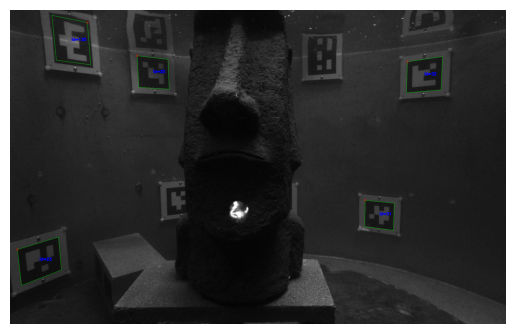

In [3]:
extract_and_generate_apriltag_msg(bag_file_path, image_topic)